In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Load behavioral data

In [2]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()

# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

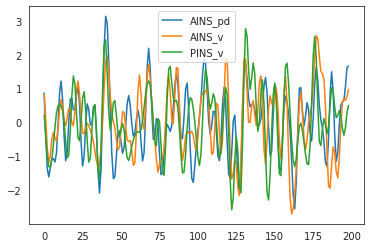

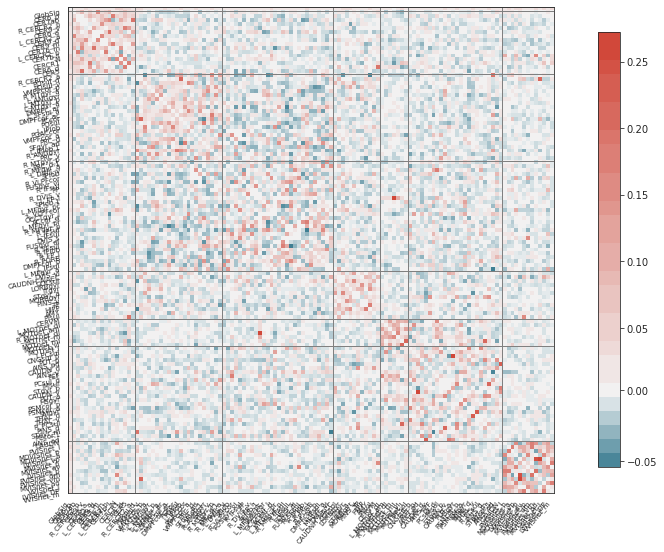

In [3]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [4]:
X.shape

(91, 123, 123)

# Load participant-level connectivity data

In [5]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    #conns_mc_model(i_a, i_b)
    conns_mc_model[:, idx] = X[:, i_a, i_b]
    #if mc_model.loc[idx, 'multi-center'] < 0:
    #    conns_mc_model[:, idx] *= -1
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.021891,0.124197,0.127759,-0.021352,0.145841,-0.064799,-0.006763,0.057262,-0.048813,-0.028449,...,0.081321,-0.046985,-0.016976,0.162298,0.075992,0.112617,-0.011008,-0.018719,-0.074869,-0.006091
1,0.015723,-0.128829,0.094542,0.125166,0.201690,-0.074666,0.017897,-0.086719,-0.122995,0.050970,...,0.033913,0.023110,-0.031482,-0.041393,0.042216,0.137049,-0.108424,-0.016450,-0.015471,0.032730
2,0.013114,-0.062290,-0.090155,0.052071,0.068738,0.030321,0.031548,0.089352,-0.032115,-0.026347,...,0.055872,-0.017286,0.022766,0.052997,-0.014386,0.104354,0.022060,0.069925,0.113806,-0.111940
3,0.020028,0.065334,-0.031791,0.147238,0.190687,0.042861,0.029229,0.056893,-0.048255,-0.086411,...,0.003797,0.066444,0.100155,0.101198,-0.015062,-0.022866,-0.129940,0.053899,-0.073163,0.060156
4,0.027947,-0.020950,-0.003799,0.133163,0.153021,-0.029537,0.018096,-0.028581,-0.038915,0.029342,...,0.057329,0.021621,-0.025921,-0.027753,0.061111,-0.010212,0.030001,-0.039720,-0.019237,0.064941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.031210,0.088623,0.011089,0.026238,0.210191,-0.017681,-0.073872,0.031895,-0.078204,0.022764,...,-0.011890,0.020761,-0.006920,0.006928,0.028016,0.040750,0.029395,-0.016146,-0.020249,0.095300
87,0.021306,0.104734,0.037766,0.173000,0.157848,-0.082971,-0.131150,-0.032904,0.017431,-0.108233,...,-0.090136,-0.047688,0.002433,0.040920,0.041044,0.042326,0.010826,0.023084,0.100832,-0.052292
88,0.014579,0.132763,-0.108385,0.099388,0.053617,0.046721,0.096082,-0.155134,-0.120663,0.104619,...,-0.181528,-0.020835,0.046505,-0.138580,0.013929,-0.049692,-0.033406,0.069901,0.094161,-0.025747
89,0.019275,0.059405,-0.146022,0.036162,0.247881,0.005831,-0.088877,-0.022490,0.169983,-0.258408,...,-0.048504,-0.016585,0.107030,-0.057102,0.093968,-0.005255,-0.034939,-0.075313,0.036747,-0.094788


In [6]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]

df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
#df2['npsq'] = df.psq * -1
#df2['nanx_state'] = df.anx_state * -1
#df2['nanx_trait'] = df.anx_trait * -1
df2['study'] = df.study.astype('category').cat.codes

#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'pcs_catastrophizing', 'pcs_rumination']]
#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k' ]]
#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'psq', 'anx_state', 'anx_trait', 'pcs_catastrophizing', 'PSQI', 'PSQ20', 'ads_k' ]]
vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'psq', 'anx_state', 'anx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k' ]]

vars.corrwith(df.mean_QST_pain_sensitivity)

CPT                    0.714782
nHPT                   0.769679
nMPT                   0.634185
nt50                   0.534950
psq                   -0.190144
anx_state             -0.202458
anx_trait             -0.204718
pcs_catastrophizing    0.134912
pcs_rumination         0.215321
PSQI                   0.296726
PSQ20                  0.308412
ads_k                  0.081807
dtype: float64

In [7]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
CPT,0.218888,0.227387,-0.231473,0.310017,0.181493,-0.136003,-0.219108,0.308218,-0.088551,0.108076,...,-0.275131,0.174136,0.243219,-0.122858,-0.173764,-0.219074,0.275399,0.066448,0.176775,0.138239
nHPT,0.161564,0.291471,-0.254461,0.347498,0.252683,-0.232522,-0.168474,0.238095,-0.113355,0.244624,...,-0.114626,0.298346,0.276420,-0.215576,-0.212870,-0.228620,0.267165,0.283450,0.274513,0.187179
nMPT,0.301945,0.136736,-0.201422,0.027588,0.164708,-0.118144,-0.093630,-0.117084,-0.064367,0.161176,...,-0.137282,0.439023,0.105791,-0.261143,-0.198211,-0.171467,0.209269,0.092689,0.348656,0.248983
nt50,0.009989,0.180914,-0.319194,0.069174,0.084996,0.015976,-0.153033,0.072413,-0.007896,-0.018929,...,-0.453834,0.408920,0.224664,0.078798,-0.138484,-0.324741,0.107535,-0.082198,0.286457,0.286114
psq,-0.361906,-0.064650,0.009865,-0.077909,-0.375797,-0.105488,-0.002857,0.178004,-0.109571,0.073121,...,-0.048563,-0.282711,0.116082,0.163604,0.022690,0.083695,-0.232201,-0.003573,-0.051586,0.010707
anx_state,-0.394896,-0.030007,0.026690,-0.001207,-0.431048,-0.144962,-0.014017,0.173659,-0.055982,0.042780,...,-0.053913,-0.260548,0.056158,0.145027,0.046263,0.179421,-0.239972,0.046450,-0.139687,0.035873
anx_trait,-0.385377,-0.002733,0.042216,-0.007472,-0.413689,-0.153239,0.005170,0.174068,-0.048025,0.017537,...,-0.008707,-0.278432,0.055220,0.171715,0.080542,0.172157,-0.250685,0.013330,-0.160756,0.021476
pcs_catastrophizing,0.005730,0.006787,-0.111155,-0.052501,0.040152,0.024004,-0.043877,0.197777,-0.023237,-0.026773,...,0.091981,0.032641,0.047185,0.161553,0.007177,0.000470,0.036557,0.087098,0.010068,-0.000595
pcs_rumination,0.159344,0.100928,-0.025577,-0.138164,0.101819,-0.262166,-0.017303,0.229777,-0.308559,0.308589,...,0.105289,-0.075319,0.031824,0.159639,-0.137901,-0.249635,0.316611,-0.046288,0.109181,0.025208
PSQI,-0.080914,0.032809,-0.190889,-0.033573,0.221576,-0.027921,-0.154723,0.241252,-0.037023,0.037168,...,0.026482,0.352548,-0.059845,-0.030204,-0.263429,-0.025996,-0.095407,0.013938,0.147407,0.015165


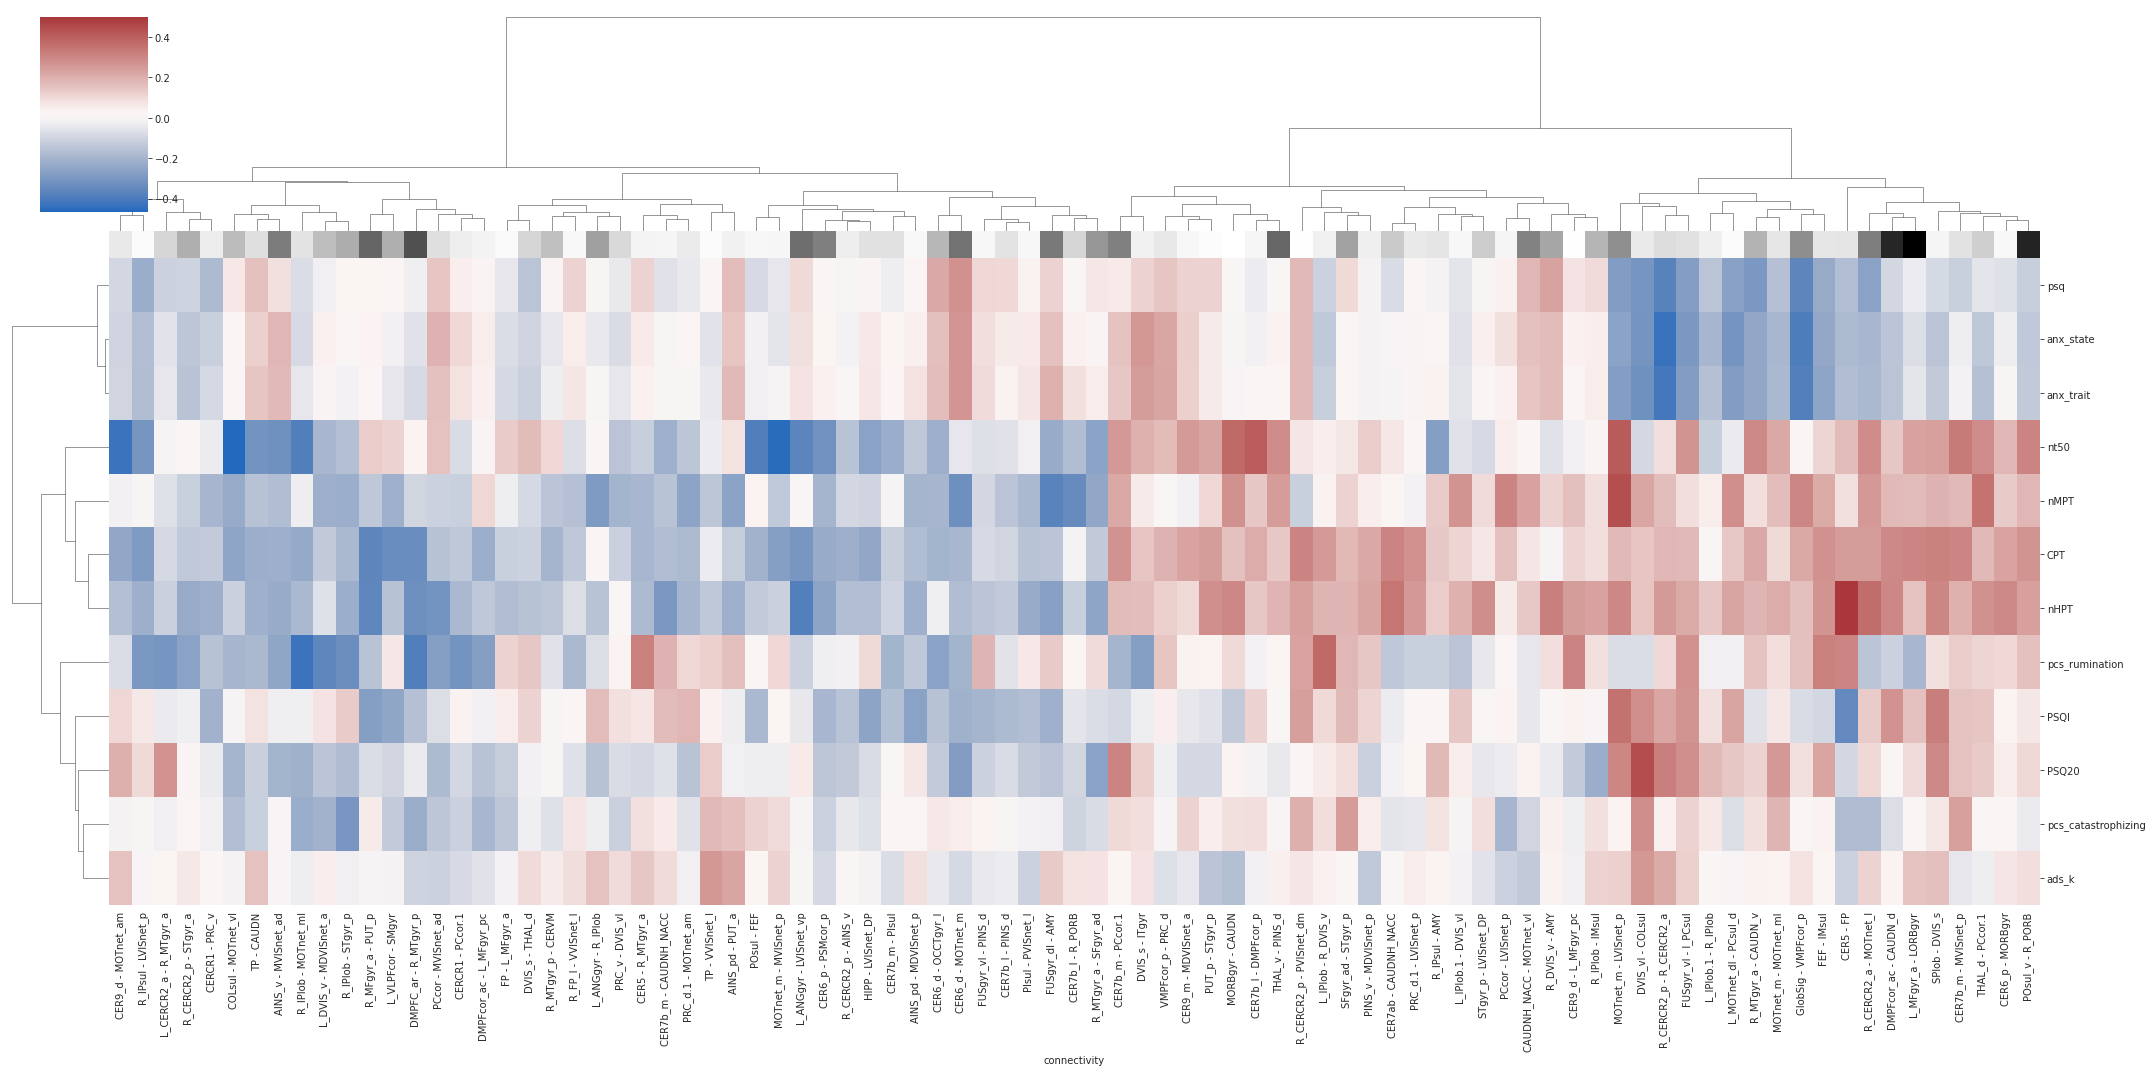

In [8]:
from sklearn.cluster import AgglomerativeClustering, KMeans
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='ward', metric='euclidean', cmap="vlag", figsize=(30,15), dendrogram_ratio=(0.05, 0.25), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [9]:
fig.savefig('../res/multi-center/cluster_map.pdf')

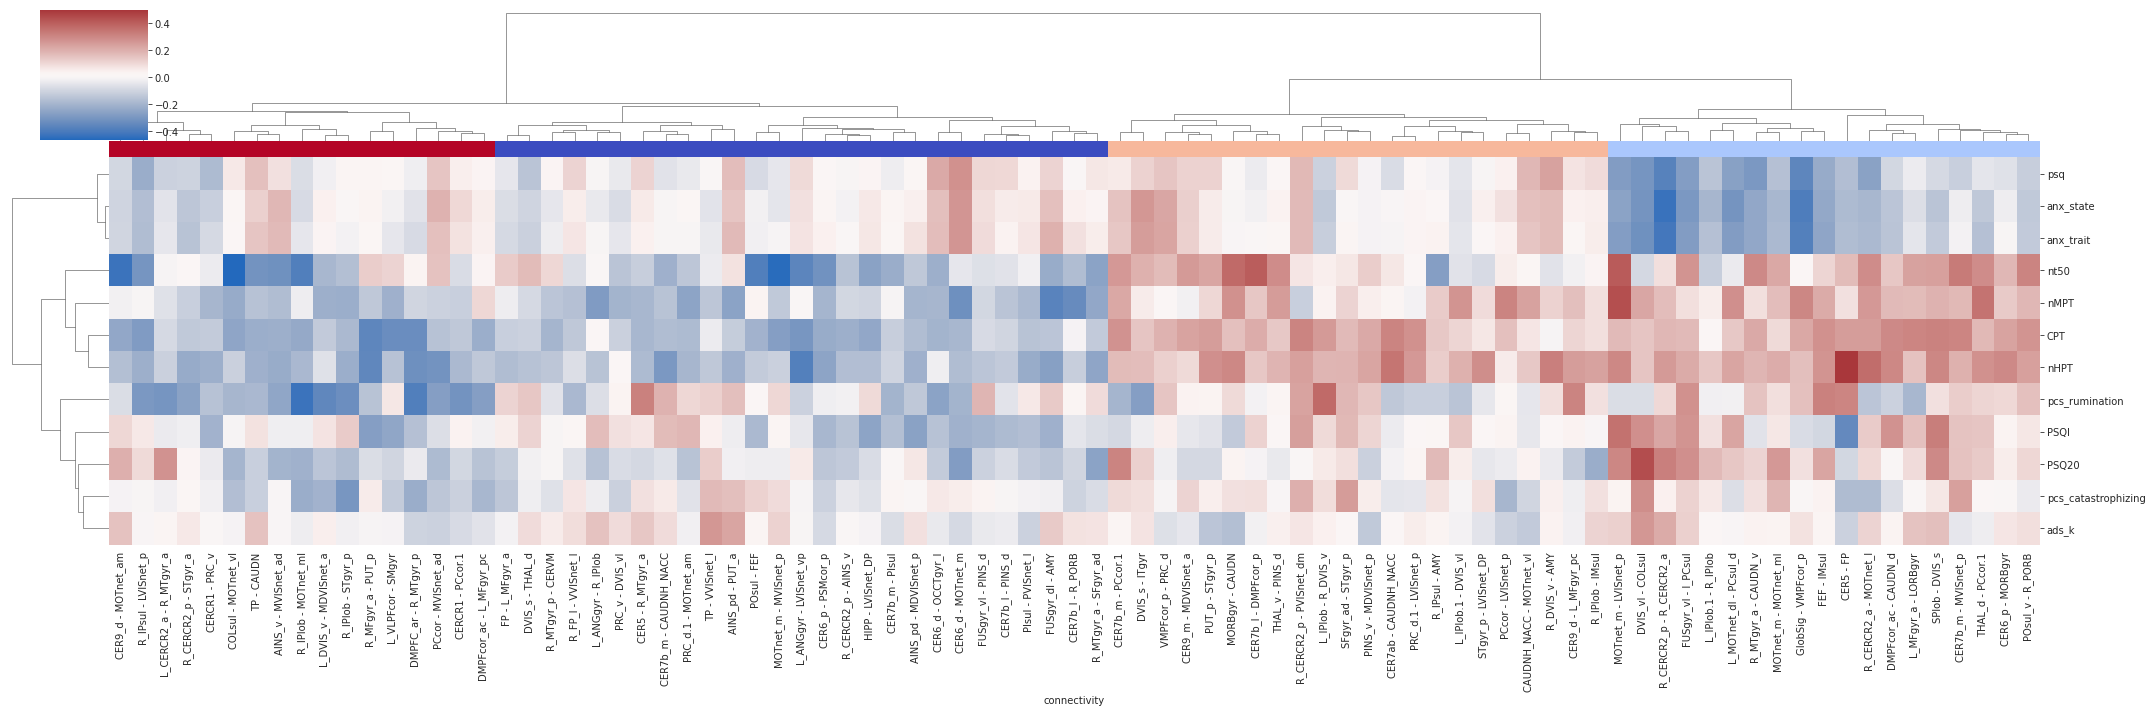

In [10]:
norm = Normalize()
component_labels = AgglomerativeClustering(n_clusters=4, linkage="ward", affinity='euclidean').fit(corrmtx.dropna().T).labels_
#component_labels = pd.DataFrame(component_labels, columns=corrmtx.columns)

fig = sns.clustermap(corrmtx.dropna(), method='ward', metric='euclidean', cmap="vlag", figsize=(30,10), dendrogram_ratio=(0.05, 0.25), col_colors=cm.coolwarm(norm(component_labels)))


In [14]:
component_labels = pd.DataFrame(component_labels)
component_labels.columns = ['label']
component_labels.index = corrmtx.columns
component_labels.to_csv('../res/multi-center/component-labels.csv')

In [81]:
fig.savefig('../res/multi-center/cluster_map2.pdf')

In [82]:
from scipy.cluster.hierarchy import dendrogram

def linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix(model), **kwargs)

2 clust:  p = 0.0


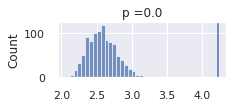

3 clust:  p = 0.0


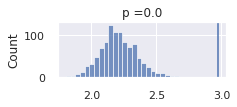

4 clust:  p = 0.103


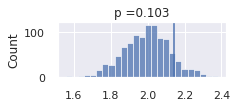

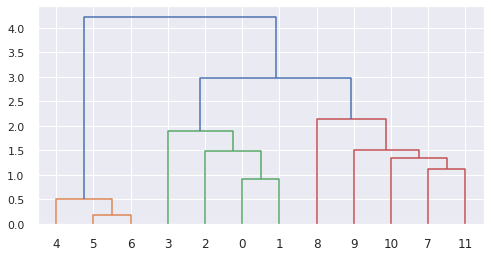

In [83]:
from joblib import Parallel, delayed

linkage = 'ward'
affinity = 'euclidean'

nperm = 1000
n_jobs=-1
depth = 6 #must be greater than 1
random_state = 42

# Actual data:
# setting distance_threshold=0 ensures we compute the full tree.
act_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=affinity)
act_model = act_model.fit(corrmtx)
act_lm = linkage_matrix(act_model)

def workhorse(seed):
    _rng = np.random.default_rng(seed)
    perm_idx = _rng.permutation(range(vars.shape[0]))
    perm_corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))
    for i in range(vars.shape[1]):
        for j in range(conns_mc_model.shape[1]):
            mask = ~np.isnan(vars.values[perm_idx,i]) & ~np.isnan(conns_mc_model.values[:,j])
            perm_corrmtx[i, j] = np.corrcoef(vars.values[perm_idx,i][mask], conns_mc_model.values[mask,j])[0,1]
    # cluster
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=affinity).fit(perm_corrmtx)
    lm = linkage_matrix(model)
    return lm[-(depth):,2]

rng = np.random.default_rng(random_state)
random_sates = rng.integers(np.iinfo(np.int32).max, size=nperm)
heights = np.array(Parallel(n_jobs=n_jobs)(delayed(workhorse)(seed) for seed in random_sates))

#results
sns.set(rc={"figure.figsize":(3, 1)})

thres = np.inf
for i in range(heights.shape[1]):
        p = np.sum(heights[:,-(i+1)] > act_lm[-(i+1),2])/nperm
        print(i+2, 'clust:  p =', p)
        sns.histplot(heights[:,-(i+1)])
        plt.axvline(act_lm[-(i+1),2])
        plt.title('p =' + str(p))
        plt.show()
        if p < 0.05:
            thres = act_lm[-(i+1),2]
        else:
            break

sns.set(rc={"figure.figsize":(8, 4)})
plot_dendrogram(act_model, color_threshold=thres)

2 clust:  p = 0.0


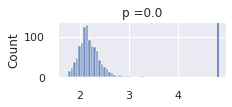

3 clust:  p = 0.0


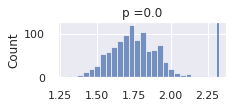

4 clust:  p = 0.617


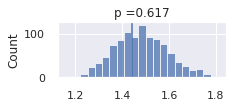

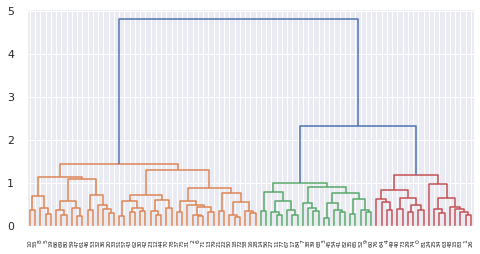

In [84]:
from joblib import Parallel, delayed

linkage = 'ward'
affinity = 'euclidean'

nperm = 1000
n_jobs=-1
depth = 6 #must be greater than 1
random_state = 42

# Actual data:
# setting distance_threshold=0 ensures we compute the full tree.
act_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=affinity)
act_model = act_model.fit(corrmtx.T)
act_lm = linkage_matrix(act_model)

def workhorse(seed):
    _rng = np.random.default_rng(seed)
    perm_idx = _rng.permutation(range(vars.shape[0]))
    perm_corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))
    for i in range(vars.shape[1]):
        for j in range(conns_mc_model.shape[1]):
            mask = ~np.isnan(vars.values[perm_idx,i]) & ~np.isnan(conns_mc_model.values[:,j])
            perm_corrmtx[i, j] = np.corrcoef(vars.values[perm_idx,i][mask], conns_mc_model.values[mask,j])[0,1]
    # cluster
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=affinity).fit(perm_corrmtx.T)
    lm = linkage_matrix(model)
    return lm[-(depth):,2]

rng = np.random.default_rng(random_state)
random_sates = rng.integers(np.iinfo(np.int32).max, size=nperm)
heights = np.array(Parallel(n_jobs=n_jobs)(delayed(workhorse)(seed) for seed in random_sates))

#results
sns.set(rc={"figure.figsize":(3, 1)})

thres = np.inf
for i in range(heights.shape[1]):
        p = np.sum(heights[:,-(i+1)] > act_lm[-(i+1),2])/nperm
        print(i+2, 'clust:  p =', p)
        sns.histplot(heights[:,-(i+1)])
        plt.axvline(act_lm[-(i+1),2])
        plt.title('p =' + str(p))
        plt.show()
        if p < 0.05:
            thres = act_lm[-(i+1),2]
        else:
            break

sns.set(rc={"figure.figsize":(8, 4)})
plot_dendrogram(act_model, color_threshold=thres)

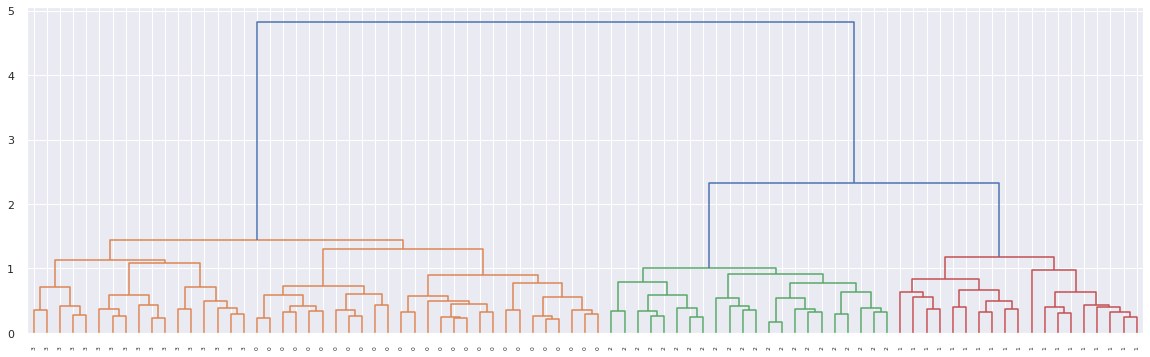

In [85]:
sns.set(rc={"figure.figsize":(20, 6)})
plot_dendrogram(act_model, color_threshold=thres, labels=component_labels.label)
sns.set(rc={"figure.figsize":(8, 4)})

In [86]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

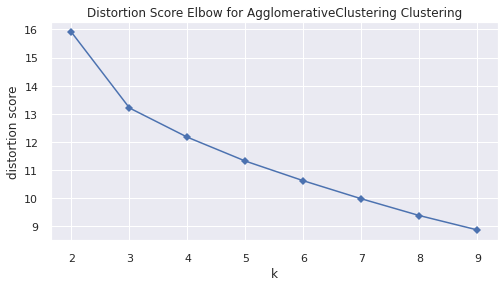

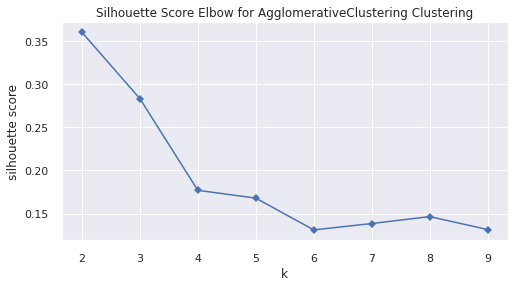

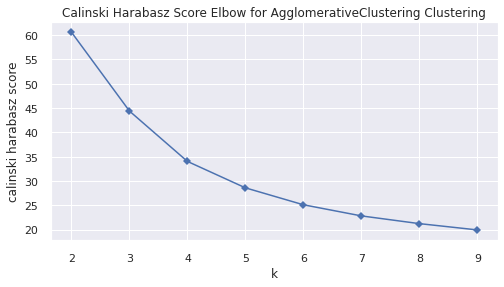

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [87]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering(linkage='ward', affinity='euclidean')
# k is range of number of clusters.
kmax = 10 #corrmtx.shape[1]
visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, locate_elbow=False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()     # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='silhouette', locate_elbow=False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='calinski_harabasz', locate_elbow=False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()

# Create component-maps: two component

/tmp/ipykernel_72487/560656024.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = mist122.get_data()


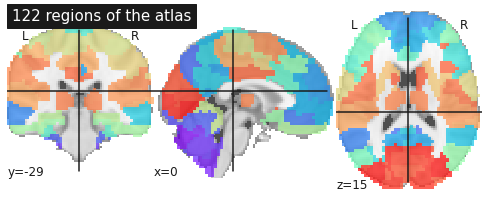

In [88]:
# get MIST atlas
from nilearn import plotting
# We show here networks of 64, 197, 444
from nilearn import image


mist122 = image.load_img('../data/atlas/MIST/atlas_relabeled.nii.gz')
data = mist122.get_data()
#data[data!=105] = 0 #test: this is anterior insula
plotting.plot_roi(mist122, cmap=cm.rainbow,
                  title='122 regions of the atlas')

In [89]:
for i in component_labels.index:
    reg_A = i.split(' - ') [0]
    reg_B = i.split(' - ') [1]
    component_labels.loc[i, 'reg_A'] = reg_A
    component_labels.loc[i, 'reg_B'] = reg_B
    component_labels.loc[i, 'idx_A'] = np.argwhere(labels==reg_A).squeeze()
    component_labels.loc[i, 'idx_B'] = np.argwhere(labels==reg_B).squeeze()

    mc_idx =mc_model['multi-center'][mc_model['connectivity']==i]
    component_labels.loc[i, 'pred_weight'] = mc_idx.values

component_labels['abs_pred_weight'] = component_labels.pred_weight.abs()
component_labels

,label,reg_A,reg_B,idx_A,idx_B,pred_weight,abs_pred_weight
connectivity,,,,,,,
GlobSig - VMPFcor_p,1,GlobSig,VMPFcor_p,0.0,19.0,0.072555,0.072555
CER6_p - MORBgyr,1,CER6_p,MORBgyr,1.0,72.0,0.004827,0.004827
CER6_p - PSMcor_p,0,CER6_p,PSMcor_p,1.0,99.0,-0.082088,0.082088
CER7ab - CAUDNH_NACC,2,CER7ab,CAUDNH_NACC,2.0,67.0,0.034224,0.034224
R_CERCR2_p - R_CERCR2_a,1,R_CERCR2_p,R_CERCR2_a,3.0,16.0,0.022155,0.022155
...,...,...,...,...,...,...,...
AINS_v - MVISnet_ad,3,AINS_v,MVISnet_ad,91.0,119.0,-0.083777,0.083777
FEF - IMsul,1,FEF,IMsul,92.0,94.0,0.016332,0.016332
STgyr_p - LVISnet_DP,2,STgyr_p,LVISnet_DP,95.0,121.0,0.032784,0.032784


# Create component-maps: four component

# COMPONENT +

/tmp/ipykernel_72487/2046505908.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
/tmp/ipykernel_72487/2046505908.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = comp.get_data()
/tmp/ipykernel_72487/2046505908.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use nump

41
0.0001226429762877 0.1633195566175285


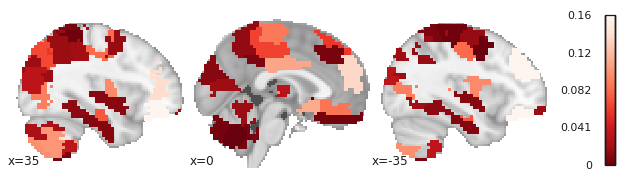

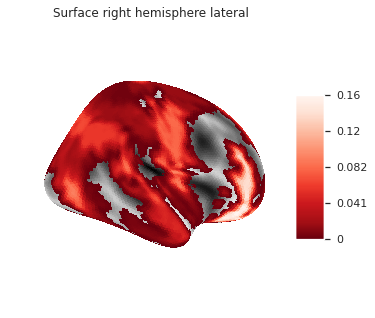

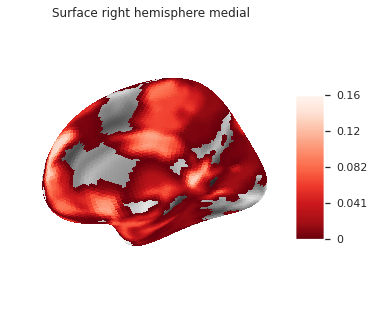

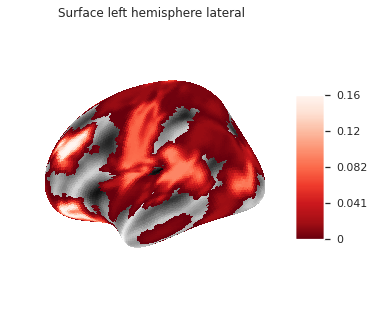

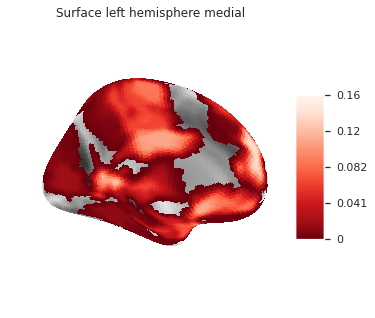

In [90]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

import nibabel as nib
comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
data = comp.get_data()
mist_data=mist122.get_data()

count = 0
for i in component_labels.index:
    if component_labels.loc[i, 'label'] == 1 or component_labels.loc[i, 'label'] == 2:
        idx_A = component_labels.loc[i, 'idx_A']
        idx_B = component_labels.loc[i, 'idx_B']
        if idx_A > 0:
            data[mist_data==idx_A] += component_labels.loc[i, 'abs_pred_weight']
        if idx_B > 0:
            data[mist_data==idx_B] += component_labels.loc[i, 'abs_pred_weight'] 
        count = count+1
print(count)

#data[data>0] = 0
#data[data<0] *= -100 #int vol
minval = data[data!=0].min()

print(minval, data.max())

#comp=image.smooth_img(comp, fwhm=1.5)

cmap = 'blue_red'
plotting.plot_stat_map(comp, threshold = 0, display_mode="x", cut_coords=[35, 0, -35], colorbar=True, cmap=cmap)

from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(comp, fsaverage.pial_right, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

texture = surface.vol_to_surf(comp, fsaverage.pial_left, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

# COMPONENT -

/tmp/ipykernel_72487/4282079447.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
/tmp/ipykernel_72487/4282079447.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = comp.get_data()
/tmp/ipykernel_72487/4282079447.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use nump

44
0.0029811812861611 0.1544620233825588


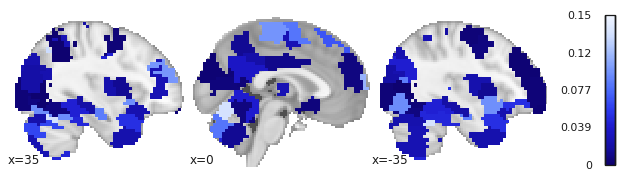

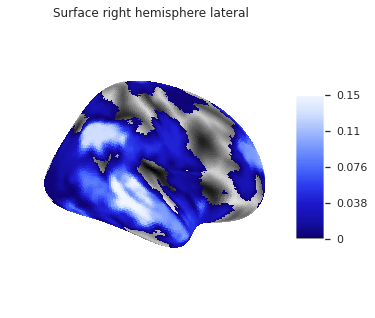

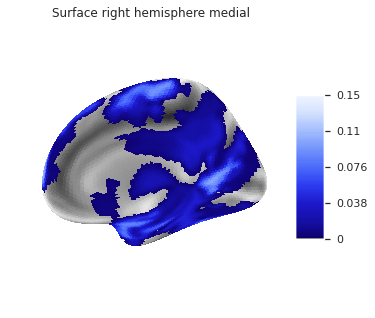

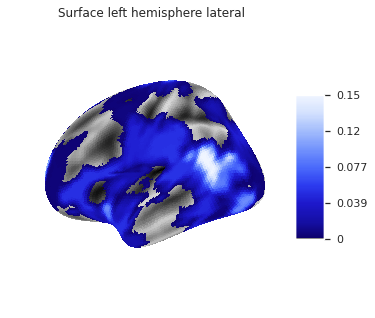

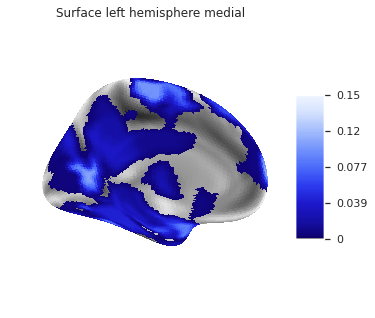

In [91]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

import nibabel as nib
comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
data = comp.get_data()
mist_data=mist122.get_data()

count = 0
for i in component_labels.index:
    if component_labels.loc[i, 'label'] == 0 or component_labels.loc[i, 'label'] == 3:
        idx_A = component_labels.loc[i, 'idx_A']
        idx_B = component_labels.loc[i, 'idx_B']
        if idx_A > 0:
            data[mist_data==idx_A] += component_labels.loc[i, 'abs_pred_weight']
        if idx_B > 0:
            data[mist_data==idx_B] += component_labels.loc[i, 'abs_pred_weight'] 
        count = count+1
print(count)

#data[data>0] = 0
#data[data<0] *= -100 #int vol
minval = data[data!=0].min()

print(minval, data.max())

#comp=image.smooth_img(comp, fwhm=1.5)

cmap = 'blue_red_r'
plotting.plot_stat_map(comp, threshold = 0, display_mode="x", cut_coords=[35, 0, -35], colorbar=True, cmap=cmap)

from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(comp, fsaverage.pial_right, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

texture = surface.vol_to_surf(comp, fsaverage.pial_left, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

# COMPONENT ++

/tmp/ipykernel_72487/2551156910.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
/tmp/ipykernel_72487/2551156910.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = comp.get_data()
/tmp/ipykernel_72487/2551156910.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use nump

19
0.0029326035942324 0.1633195566175285


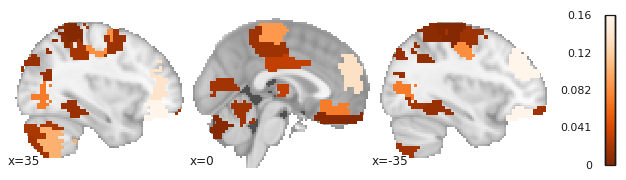

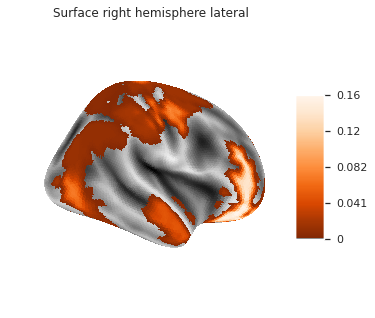

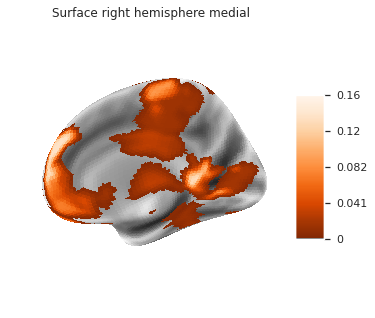

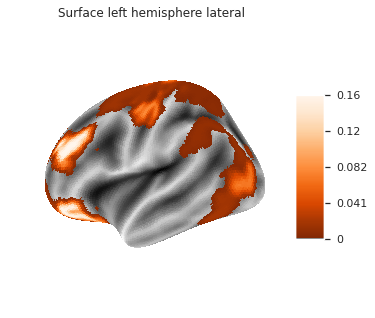

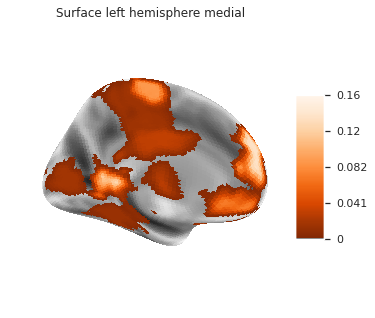

In [92]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

import nibabel as nib
comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
data = comp.get_data()
mist_data=mist122.get_data()

count = 0
for i in component_labels.index:
    if component_labels.loc[i, 'label'] == 1:
        idx_A = component_labels.loc[i, 'idx_A']
        idx_B = component_labels.loc[i, 'idx_B']
        if idx_A > 0:
            data[mist_data==idx_A] += component_labels.loc[i, 'abs_pred_weight']
        if idx_B > 0:
            data[mist_data==idx_B] += component_labels.loc[i, 'abs_pred_weight'] 
        count = count+1
print(count)

#data[data>0] = 0
#data[data<0] *= -100 #int vol
minval = data[data!=0].min()

print(minval, data.max())

#comp=image.smooth_img(comp, fwhm=1.5)

cmap = 'blue_orange'
plotting.plot_stat_map(comp, threshold = 0, display_mode="x", cut_coords=[35, 0, -35], colorbar=True, cmap=cmap)

from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(comp, fsaverage.pial_right, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

texture = surface.vol_to_surf(comp, fsaverage.pial_left, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

# COMPONENT +-

/tmp/ipykernel_72487/3303490764.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
/tmp/ipykernel_72487/3303490764.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = comp.get_data()
/tmp/ipykernel_72487/3303490764.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use nump

22
0.0001226429762877 0.11455643405314439


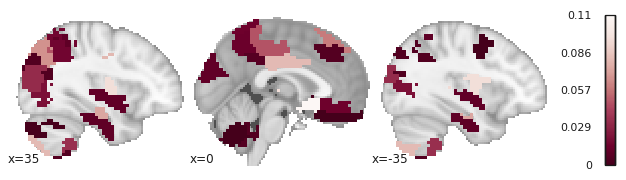

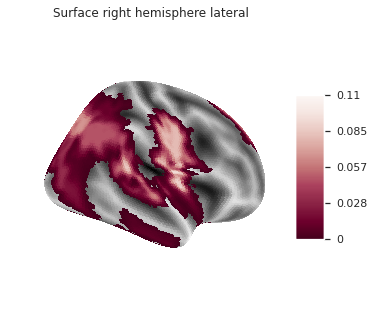

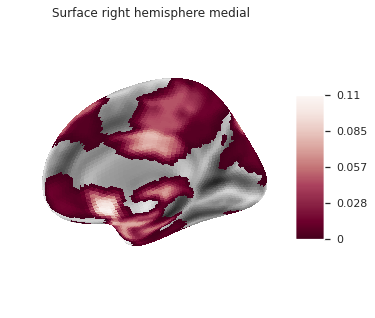

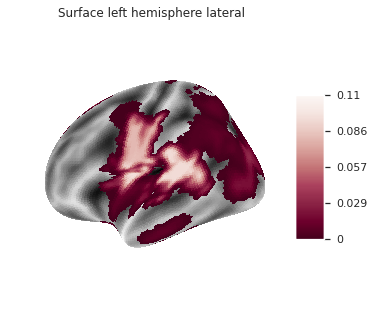

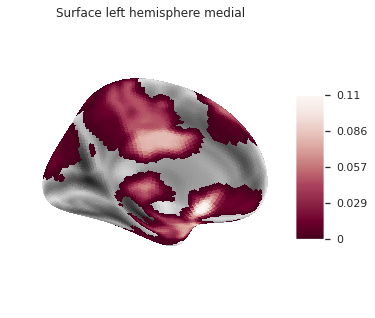

In [93]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

import nibabel as nib
comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
data = comp.get_data()
mist_data=mist122.get_data()

count = 0
for i in component_labels.index:
    if component_labels.loc[i, 'label'] == 2:
        idx_A = component_labels.loc[i, 'idx_A']
        idx_B = component_labels.loc[i, 'idx_B']
        if idx_A > 0:
            data[mist_data==idx_A] += component_labels.loc[i, 'abs_pred_weight']
        if idx_B > 0:
            data[mist_data==idx_B] += component_labels.loc[i, 'abs_pred_weight'] 
        count = count+1
print(count)

#data[data>0] = 0
#data[data<0] *= -100 #int vol
minval = data[data!=0].min()

print(minval, data.max())

#comp=image.smooth_img(comp, fwhm=1.5)

cmap = 'purple_green_r'
plotting.plot_stat_map(comp, threshold = 0, display_mode="x", cut_coords=[35, 0, -35], colorbar=True, cmap=cmap)

from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(comp, fsaverage.pial_right, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

texture = surface.vol_to_surf(comp, fsaverage.pial_left, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

# COMPONENT -+

/tmp/ipykernel_72487/3338476635.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
/tmp/ipykernel_72487/3338476635.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = comp.get_data()
/tmp/ipykernel_72487/3338476635.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use nump

17
0.0029811812861611 0.1120558517876515


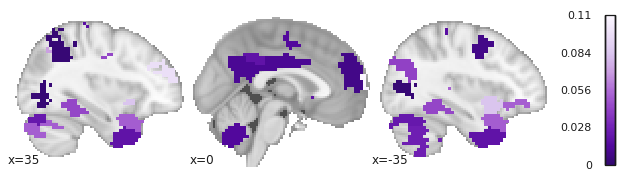

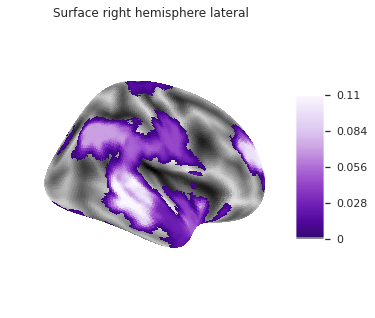

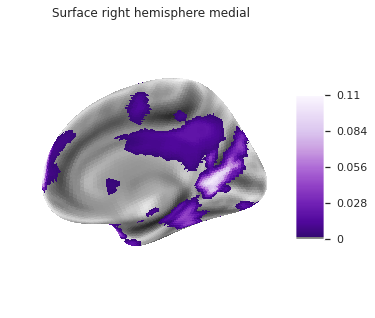

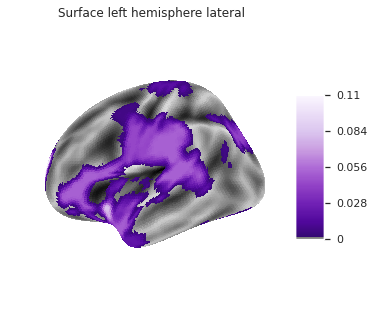

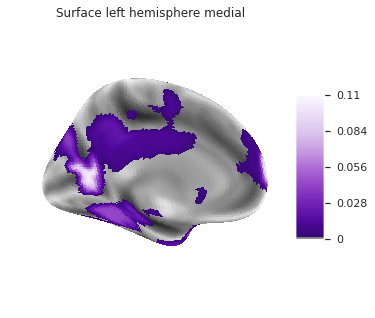

In [94]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

import nibabel as nib
comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
data = comp.get_data()
mist_data=mist122.get_data()

count = 0
for i in component_labels.index:
    if component_labels.loc[i, 'label'] == 3:
        idx_A = component_labels.loc[i, 'idx_A']
        idx_B = component_labels.loc[i, 'idx_B']
        if idx_A > 0:
            data[mist_data==idx_A] += component_labels.loc[i, 'abs_pred_weight']
        if idx_B > 0:
            data[mist_data==idx_B] += component_labels.loc[i, 'abs_pred_weight'] 
        count = count+1
print(count)

#data[data>0] = 0
#data[data<0] *= -100 #int vol
minval = data[data!=0].min()

print(minval, data.max())

#comp=image.smooth_img(comp, fwhm=1.5)

cmap = 'purple_blue_r'
plotting.plot_stat_map(comp, threshold = 0, display_mode="x", cut_coords=[35, 0, -35], colorbar=True, cmap=cmap)

from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(comp, fsaverage.pial_right, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

texture = surface.vol_to_surf(comp, fsaverage.pial_left, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

# COMPONENT --

/tmp/ipykernel_72487/3809765708.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
/tmp/ipykernel_72487/3809765708.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = comp.get_data()
/tmp/ipykernel_72487/3809765708.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use nump

27
0.0031453646604047 0.1544620233825588


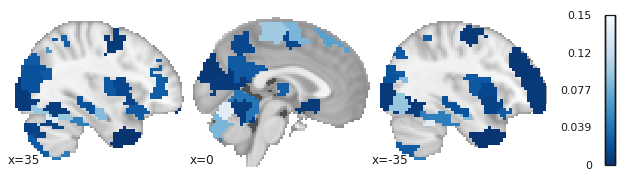

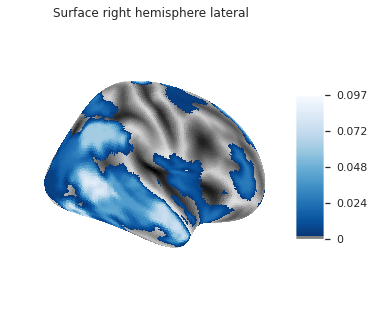

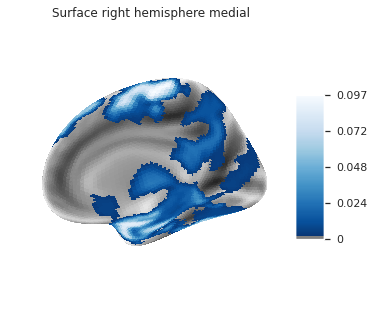

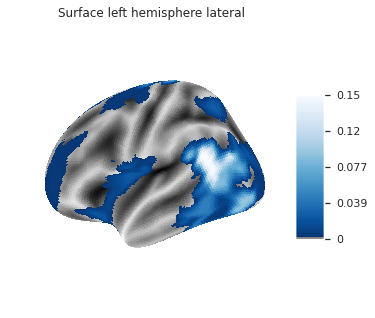

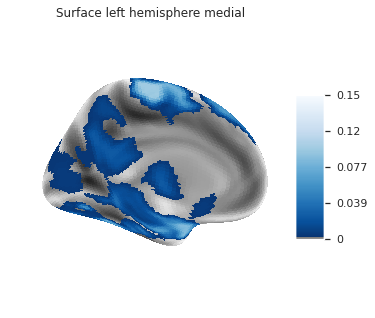

In [95]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

import nibabel as nib
comp = nib.Nifti2Image(np.zeros(mist122.get_data().shape), mist122.affine)
data = comp.get_data()
mist_data=mist122.get_data()

count = 0
for i in component_labels.index:
    if component_labels.loc[i, 'label'] == 0:
        idx_A = component_labels.loc[i, 'idx_A']
        idx_B = component_labels.loc[i, 'idx_B']
        if idx_A > 0:
            data[mist_data==idx_A] += component_labels.loc[i, 'abs_pred_weight']
        if idx_B > 0:
            data[mist_data==idx_B] += component_labels.loc[i, 'abs_pred_weight'] 
        count = count+1
print(count)

#data[data>0] = 0
#data[data<0] *= -100 #int vol
minval = data[data!=0].min()

print(minval, data.max())

#comp=image.smooth_img(comp, fwhm=1.5)

cmap = 'brown_cyan'
plotting.plot_stat_map(comp, threshold = 0, display_mode="x", cut_coords=[35, 0, -35], colorbar=True, cmap=cmap)

from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(comp, fsaverage.pial_right, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_right, cmap=cmap)
plotting.show()

texture = surface.vol_to_surf(comp, fsaverage.pial_left, kind='ball', radius=5)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere lateral', colorbar=True, view='lateral',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere medial', colorbar=True, view='medial',
                            threshold=minval, bg_map=fsaverage.sulc_left, cmap=cmap)
plotting.show()

# plot some variables per component

In [96]:
df = corrmtx.melt(ignore_index=False).reset_index()
df = df.rename(columns = {'index':'variable'})
df = df.merge(component_labels[['label']], left_on='connectivity', right_index=True).copy()
# reorder
df['component'] = df.label
#df.component = df.component.replace({0:'C++', 1:'C--', 2:'C+-', 3:'C-+'})
df

,variable,connectivity,value,label,component
0,CPT,GlobSig - VMPFcor_p,0.218888,1,1
1,nHPT,GlobSig - VMPFcor_p,0.161564,1,1
2,nMPT,GlobSig - VMPFcor_p,0.301945,1,1
3,nt50,GlobSig - VMPFcor_p,0.009989,1,1
4,psq,GlobSig - VMPFcor_p,-0.361906,1,1
...,...,...,...,...,...
1015,pcs_catastrophizing,THAL_v - PINS_d,-0.000595,2,2
1016,pcs_rumination,THAL_v - PINS_d,0.025208,2,2
1017,PSQI,THAL_v - PINS_d,0.015165,2,2
1018,PSQ20,THAL_v - PINS_d,-0.040917,2,2


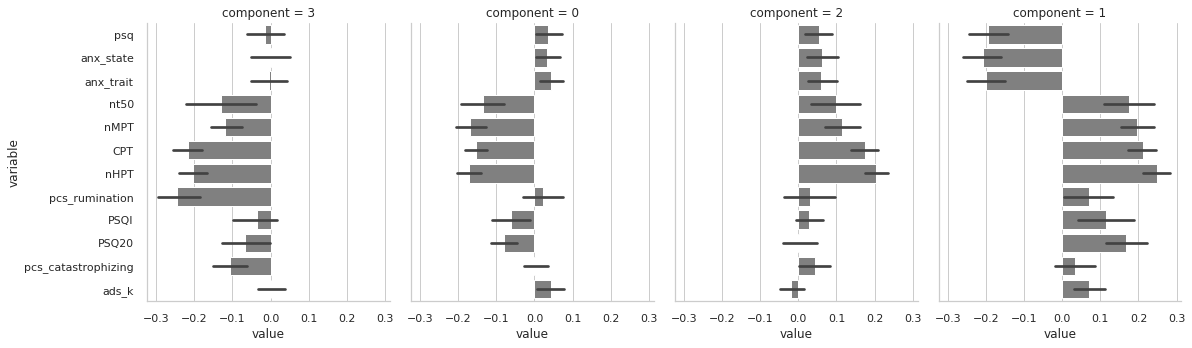

In [97]:
sns.set_style("whitegrid")
fig=sns.catplot(x="value", y="variable", col="component", col_wrap=6, kind='bar', orient='h', aspect=0.8,
                col_order=[3, 0, 2, 1],
                order=['psq', 'anx_state', 'anx_trait', 'nt50', 'nMPT', 'CPT', 'nHPT',
                       'pcs_rumination', 'PSQI', 'PSQ20', 'pcs_catastrophizing', 'ads_k'],
                color='gray',
              data=df, ci=95)
fig.savefig('../res/multi-center/cluster_barplot.pdf')

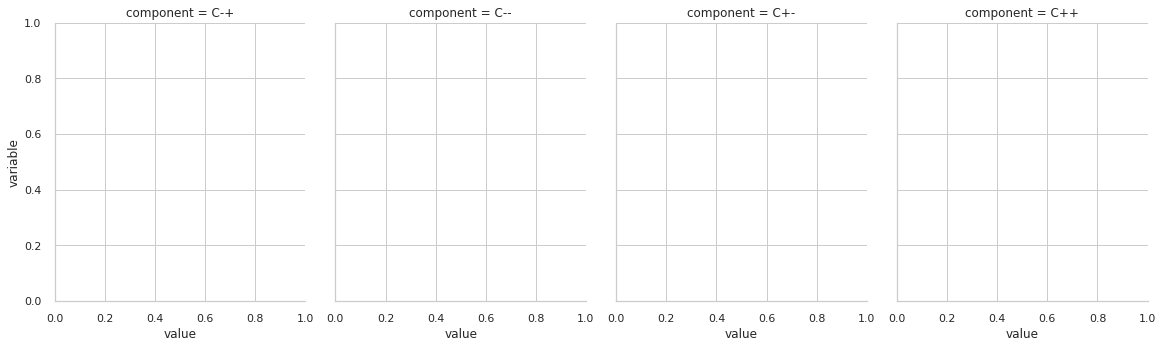

In [98]:
sns.set_style("whitegrid")

from importlib import reload  

import seaborn.categorical
reload(seaborn.categorical)

seaborn.categorical._Old_Violin = seaborn.categorical._ViolinPlotter

# monkey-patching
class _My_ViolinPlotter(seaborn.categorical._Old_Violin):

    def __init__(self, *args, **kwargs):
        super(_My_ViolinPlotter, self).__init__(*args, **kwargs)
        self.gray='black'

seaborn.categorical._ViolinPlotter = _My_ViolinPlotter

sns.catplot(x="value", y="variable", col="component", col_wrap=6, kind='violin', orient='h', aspect=0.8,
            col_order=['C-+', 'C--', 'C+-', 'C++'], color='white', inner='box',
              data=df)


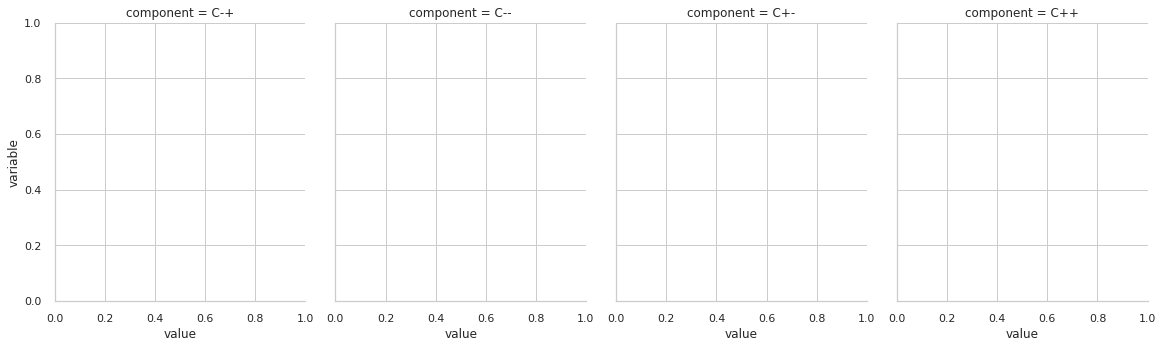

In [99]:
sns.set_style("whitegrid")
sns.catplot(x="value", y="variable", col="component", col_wrap=6, kind='strip', orient='h', aspect=0.8,
            col_order=['C-+', 'C--', 'C+-', 'C++'], color='gray', alpha=0.5,
              data=df)

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


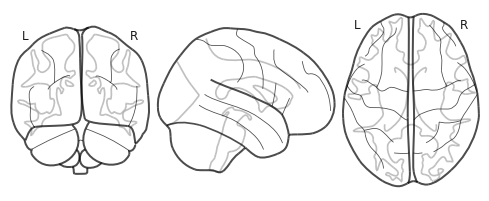

In [100]:
plotting.plot_glass_brain(comp, threshold = 100)